In [ ]:
!pip install tensorflow_docs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.7/182.7 kB 5.5 MB/s eta 0:00:00


In [ ]:
import zipfile
import tensorflow as tf
from PIL import Image
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
import os
import glob
import imageio
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, LeakyReLU, Activation
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, Sequential
from tqdm import tqdm
import PIL
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
from skimage.transform import resize
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed

#EXTRACT ZIP

In [ ]:
#Load Dataset
data_path = "/content/"

zip_files = ["B_23-20250626T190155Z-1.zip"]
extract_path = "/content/dataset"

os.makedirs(extract_path, exist_ok=True)

for zip_file in zip_files:
    with zipfile.ZipFile(os.path.join(data_path, zip_file), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

#PREP

In [ ]:
#Gambar
image_paths = glob.glob(os.path.join(extract_path, "**", "*.jpg"), recursive=True)

#Fungsi untuk load, resize, dan normalize
def load_and_preprocess(paths, target_size=(100,100)):
    images = []
    for p in paths:
        img = cv2.imread(p, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #convert ke RGB
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA) #resize ke 100x100
        images.append(img)
    arr = np.array(images, dtype=np.float32)
    #Normalisasi ke [-1, +1] untuk GAN
    arr = (arr / 127.5) - 1.0
    return arr

#Load & preprocess seluruh dataset
real_images = load_and_preprocess(image_paths)
print("Real images shape:", real_images.shape)  # (n_samples, 100, 100, 3)
print("Pixel range:", real_images.min(), "to", real_images.max())

#Siapkan noise input untuk generator
#noise berbentuk gambar gaussian dengan mean=0, std=1
def sample_noise(batch_size, img_shape=(100,100,3)):
    return np.random.normal(loc=0.0, scale=1.0,
                            size=(batch_size, *img_shape)).astype(np.float32)

#Contoh: buat 8 buah noise images
noise_samples = sample_noise(8)
print("Noise shape:", noise_samples.shape)
print("Noise stats: mean=", noise_samples.mean(), "std=", noise_samples.std())

Real images shape: (1074, 100, 100, 3)
Pixel range: -1.0 to 1.0
Noise shape: (8, 100, 100, 3)
Noise stats: mean= -0.0021624374 std= 1.0016475


#A) GAN

In [ ]:
latent_dim=100

#Generator
def make_generator_model(latent_dim=100):
    model = Sequential(name="Generator")

    #Dense + reshape ke 94×94×64
    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(94*94*64, use_bias=False))
    model.add(layers.Reshape((94, 94, 64)))

    #Conv2DTranspose: 94 -> 96
    model.add(layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.ReLU())

    #96 -> 98
    model.add(layers.Conv2DTranspose(32, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.ReLU())

    #98 -> 100
    model.add(layers.Conv2DTranspose(16, kernel_size=3, strides=1, padding='valid'))
    model.add(layers.ReLU())

    #Output: 100×100×3
    model.add(layers.Conv2DTranspose(3, kernel_size=1, strides=1, activation='tanh'))

    return model


In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1074

train_dataset = tf.data.Dataset.from_tensor_slices(real_images) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

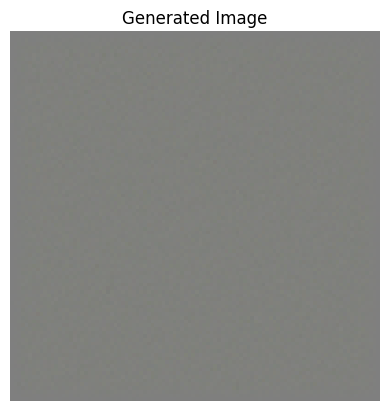

In [ ]:
#Visualisasi hasil generator (1 gambar)
generator = make_generator_model()
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=False)
generated_image = 0.5 * generated_image + 0.5  #denormalisasi [-1,1] -> [0,1]

plt.imshow(generated_image[0])
plt.axis('off')
plt.title("Generated Image")
plt.show()

In [ ]:
#Discriminator
def make_discriminator_model():
    model = tf.keras.Sequential(name="Discriminator")
    model.add(layers.Input(shape=(100, 100, 3)))

    model.add(layers.Conv2D(16, (3, 3), strides=1, padding='valid'))
    model.add(layers.ReLU())

    model.add(layers.Conv2D(32, (3, 3), strides=1, padding='valid'))
    model.add(layers.ReLU())

    model.add(layers.Conv2D(64, (3, 3), strides=1, padding='valid'))
    model.add(layers.ReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
#Buat generator dan discriminator
generator = make_generator_model()
discriminator = make_discriminator_model()

#Buat 1 sample noise dan hasilkan gambar
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

#Masukkan ke discriminator
decision = discriminator(generated_image)

print("Discriminator output:", decision.numpy())

Discriminator output: [[0.49936327]]


In [ ]:
#Binary crossentropy sesuai output sigmoid (from_logits=False)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

#Discriminator loss: gabungan real dan fake loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   #real label = 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  #fake label = 0
    total_loss = real_loss + fake_loss
    return total_loss

#Generator loss: berharap semua output dianggap real
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)  #ingin dianggap real (label=1)

#Optimizer: Adam
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5)


In [ ]:
#Parameter
EPOCHS = 1000
latent_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, latent_dim])

In [ ]:
generator_losses = []
discriminator_losses = []

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #Hasilkan gambar palsu dari generator
        generated_images = generator(noise, training=True)

        #Evaluasi oleh diskriminator
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #Hitung loss
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    #Hitung dan terapkan gradien
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        total_gen_loss = 0.0
        total_disc_loss = 0.0
        batch_count = 0

        print(f"\nEpoch {epoch+1}/{epochs}")
        for image_batch in tqdm(dataset, desc=f"Training Epoch {epoch+1}", leave=False):
            gen_loss, disc_loss = train_step(image_batch)
            total_gen_loss += gen_loss.numpy()
            total_disc_loss += disc_loss.numpy()
            batch_count += 1

        #Rata-rata loss per epoch
        avg_gen_loss = total_gen_loss / batch_count
        avg_disc_loss = total_disc_loss / batch_count
        generator_losses.append(avg_gen_loss)
        discriminator_losses.append(avg_disc_loss)

        #Save image & print loss
        if (epoch + 1) % 10 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
            generate_and_save_images(generator, epoch + 1, seed)
            print(f"Epoch {epoch+1} - Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}")

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = 0.5 * predictions + 0.5  #Scale [-1,1] to [0,1]

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('image_results', exist_ok=True)
    plt.savefig(f'image_results/image_epoch_{epoch:03d}.png')
    plt.close()


In [ ]:
train(train_dataset, EPOCHS)


Epoch 1/1000


Epoch 1 - Gen Loss: 3.3414, Disc Loss: 0.2338

Epoch 2/1000



Epoch 3/1000



Epoch 4/1000



Epoch 5/1000



Epoch 6/1000



Epoch 7/1000



Epoch 8/1000



Epoch 9/1000



Epoch 10/1000


Epoch 10 - Gen Loss: 2.7919, Disc Loss: 0.3382

Epoch 11/1000



Epoch 12/1000



Epoch 13/1000



Epoch 14/1000



Epoch 15/1000



Epoch 16/1000



Epoch 17/1000



Epoch 18/1000



Epoch 19/1000



Epoch 20/1000


Epoch 20 - Gen Loss: 2.1154, Disc Loss: 0.4955

Epoch 21/1000



Epoch 22/1000



Epoch 23/1000



Epoch 24/1000



Epoch 25/1000



Epoch 26/1000



Epoch 27/1000



Epoch 28/1000



Epoch 29/1000



Epoch 30/1000


Epoch 30 - Gen Loss: 2.0898, Disc Loss: 0.4716

Epoch 31/1000



Epoch 32/1000



Epoch 33/1000



Epoch 34/1000



Epoch 35/1000



Epoch 36/1000



Epoch 37/1000



Epoch 38/1000



Epoch 39/1000



Epoch 40/1000


Epoch 40 - Gen Loss: 2.3970, Disc Loss: 0.4200

Epoch 41/1000



Epoch 42/1000



Epoch 43/1000



Epoch 44/1000



Epoch 45/1000



Epoch 46/1000



Epoch 47/1000



Epoch 48/1000



Epoch 49/1000



Epoch 50/1000


Epoch 50 - Gen Loss: 1.9606, Disc Loss: 0.6105

Epoch 51/1000



Epoch 52/1000



Epoch 53/1000



Epoch 54/1000



Epoch 55/1000



Epoch 56/1000



Epoch 57/1000



Epoch 58/1000



Epoch 59/1000



Epoch 60/1000


Epoch 60 - Gen Loss: 1.9075, Disc Loss: 0.5587

Epoch 61/1000



Epoch 62/1000



Epoch 63/1000



Epoch 64/1000



Epoch 65/1000



Epoch 66/1000



Epoch 67/1000



Epoch 68/1000



Epoch 69/1000



Epoch 70/1000


Epoch 70 - Gen Loss: 1.9337, Disc Loss: 0.5751

Epoch 71/1000



Epoch 72/1000



Epoch 73/1000



Epoch 74/1000



Epoch 75/1000



Epoch 76/1000



Epoch 77/1000



Epoch 78/1000



Epoch 79/1000



Epoch 80/1000


Epoch 80 - Gen Loss: 1.6020, Disc Loss: 0.6928

Epoch 81/1000



Epoch 82/1000



Epoch 83/1000



Epoch 84/1000



Epoch 85/1000



Epoch 86/1000



Epoch 87/1000



Epoch 88/1000



Epoch 89/1000



Epoch 90/1000


Epoch 90 - Gen Loss: 1.8256, Disc Loss: 0.6605

Epoch 91/1000



Epoch 92/1000



Epoch 93/1000



Epoch 94/1000



Epoch 95/1000



Epoch 96/1000



Epoch 97/1000



Epoch 98/1000



Epoch 99/1000



Epoch 100/1000


Epoch 100 - Gen Loss: 1.7539, Disc Loss: 0.6017

Epoch 101/1000



Epoch 102/1000



Epoch 103/1000



Epoch 104/1000



Epoch 105/1000



Epoch 106/1000



Epoch 107/1000



Epoch 108/1000



Epoch 109/1000



Epoch 110/1000


Epoch 110 - Gen Loss: 1.6224, Disc Loss: 0.6730

Epoch 111/1000



Epoch 112/1000



Epoch 113/1000



Epoch 114/1000



Epoch 115/1000



Epoch 116/1000



Epoch 117/1000



Epoch 118/1000



Epoch 119/1000



Epoch 120/1000


Epoch 120 - Gen Loss: 1.6281, Disc Loss: 0.7018

Epoch 121/1000



Epoch 122/1000



Epoch 123/1000



Epoch 124/1000



Epoch 125/1000



Epoch 126/1000



Epoch 127/1000



Epoch 128/1000



Epoch 129/1000



Epoch 130/1000


Epoch 130 - Gen Loss: 1.6053, Disc Loss: 0.7016

Epoch 131/1000



Epoch 132/1000



Epoch 133/1000



Epoch 134/1000



Epoch 135/1000



Epoch 136/1000



Epoch 137/1000



Epoch 138/1000



Epoch 139/1000



Epoch 140/1000


Epoch 140 - Gen Loss: 1.6699, Disc Loss: 0.6497

Epoch 141/1000



Epoch 142/1000



Epoch 143/1000



Epoch 144/1000



Epoch 145/1000



Epoch 146/1000



Epoch 147/1000



Epoch 148/1000



Epoch 149/1000



Epoch 150/1000


Epoch 150 - Gen Loss: 1.8306, Disc Loss: 0.6206

Epoch 151/1000



Epoch 152/1000



Epoch 153/1000



Epoch 154/1000



Epoch 155/1000



Epoch 156/1000



Epoch 157/1000



Epoch 158/1000



Epoch 159/1000



Epoch 160/1000


Epoch 160 - Gen Loss: 1.7967, Disc Loss: 0.6058

Epoch 161/1000



Epoch 162/1000



Epoch 163/1000



Epoch 164/1000



Epoch 165/1000



Epoch 166/1000



Epoch 167/1000



Epoch 168/1000



Epoch 169/1000



Epoch 170/1000


Epoch 170 - Gen Loss: 1.7046, Disc Loss: 0.6545

Epoch 171/1000



Epoch 172/1000



Epoch 173/1000



Epoch 174/1000



Epoch 175/1000



Epoch 176/1000



Epoch 177/1000



Epoch 178/1000



Epoch 179/1000



Epoch 180/1000


Epoch 180 - Gen Loss: 1.8205, Disc Loss: 0.5670

Epoch 181/1000



Epoch 182/1000



Epoch 183/1000



Epoch 184/1000



Epoch 185/1000



Epoch 186/1000



Epoch 187/1000



Epoch 188/1000



Epoch 189/1000



Epoch 190/1000


Epoch 190 - Gen Loss: 1.8553, Disc Loss: 0.5699

Epoch 191/1000



Epoch 192/1000



Epoch 193/1000



Epoch 194/1000



Epoch 195/1000



Epoch 196/1000



Epoch 197/1000



Epoch 198/1000



Epoch 199/1000



Epoch 200/1000


Epoch 200 - Gen Loss: 1.9404, Disc Loss: 0.5190

Epoch 201/1000



Epoch 202/1000



Epoch 203/1000



Epoch 204/1000



Epoch 205/1000



Epoch 206/1000



Epoch 207/1000



Epoch 208/1000



Epoch 209/1000



Epoch 210/1000


Epoch 210 - Gen Loss: 1.9571, Disc Loss: 0.5447

Epoch 211/1000



Epoch 212/1000



Epoch 213/1000



Epoch 214/1000



Epoch 215/1000



Epoch 216/1000



Epoch 217/1000



Epoch 218/1000



Epoch 219/1000



Epoch 220/1000


Epoch 220 - Gen Loss: 2.0596, Disc Loss: 0.4939

Epoch 221/1000



Epoch 222/1000



Epoch 223/1000



Epoch 224/1000



Epoch 225/1000



Epoch 226/1000



Epoch 227/1000



Epoch 228/1000



Epoch 229/1000



Epoch 230/1000


Epoch 230 - Gen Loss: 2.1161, Disc Loss: 0.4823

Epoch 231/1000



Epoch 232/1000



Epoch 233/1000



Epoch 234/1000



Epoch 235/1000



Epoch 236/1000



Epoch 237/1000



Epoch 238/1000



Epoch 239/1000



Epoch 240/1000


Epoch 240 - Gen Loss: 2.1481, Disc Loss: 0.4565

Epoch 241/1000



Epoch 242/1000



Epoch 243/1000



Epoch 244/1000



Epoch 245/1000



Epoch 246/1000



Epoch 247/1000



Epoch 248/1000



Epoch 249/1000



Epoch 250/1000


Epoch 250 - Gen Loss: 2.1553, Disc Loss: 0.4416

Epoch 251/1000



Epoch 252/1000



Epoch 253/1000



Epoch 254/1000



Epoch 255/1000



Epoch 256/1000



Epoch 257/1000



Epoch 258/1000



Epoch 259/1000



Epoch 260/1000


Epoch 260 - Gen Loss: 2.3577, Disc Loss: 0.4142

Epoch 261/1000



Epoch 262/1000



Epoch 263/1000



Epoch 264/1000



Epoch 265/1000



Epoch 266/1000



Epoch 267/1000



Epoch 268/1000



Epoch 269/1000



Epoch 270/1000


Epoch 270 - Gen Loss: 2.3129, Disc Loss: 0.4341

Epoch 271/1000



Epoch 272/1000



Epoch 273/1000



Epoch 274/1000



Epoch 275/1000



Epoch 276/1000



Epoch 277/1000



Epoch 278/1000



Epoch 279/1000



Epoch 280/1000


Epoch 280 - Gen Loss: 2.3612, Disc Loss: 0.4038

Epoch 281/1000



Epoch 282/1000



Epoch 283/1000



Epoch 284/1000



Epoch 285/1000



Epoch 286/1000



Epoch 287/1000



Epoch 288/1000



Epoch 289/1000



Epoch 290/1000


Epoch 290 - Gen Loss: 2.5020, Disc Loss: 0.3982

Epoch 291/1000



Epoch 292/1000



Epoch 293/1000



Epoch 294/1000



Epoch 295/1000



Epoch 296/1000



Epoch 297/1000



Epoch 298/1000



Epoch 299/1000



Epoch 300/1000


Epoch 300 - Gen Loss: 2.5544, Disc Loss: 0.4126

Epoch 301/1000



Epoch 302/1000



Epoch 303/1000



Epoch 304/1000



Epoch 305/1000



Epoch 306/1000



Epoch 307/1000



Epoch 308/1000



Epoch 309/1000



Epoch 310/1000


Epoch 310 - Gen Loss: 2.6056, Disc Loss: 0.3663

Epoch 311/1000



Epoch 312/1000



Epoch 313/1000



Epoch 314/1000



Epoch 315/1000



Epoch 316/1000



Epoch 317/1000



Epoch 318/1000



Epoch 319/1000



Epoch 320/1000


Epoch 320 - Gen Loss: 2.6866, Disc Loss: 0.3757

Epoch 321/1000



Epoch 322/1000



Epoch 323/1000



Epoch 324/1000



Epoch 325/1000



Epoch 326/1000



Epoch 327/1000



Epoch 328/1000



Epoch 329/1000



Epoch 330/1000


Epoch 330 - Gen Loss: 2.7916, Disc Loss: 0.3452

Epoch 331/1000



Epoch 332/1000



Epoch 333/1000



Epoch 334/1000



Epoch 335/1000



Epoch 336/1000



Epoch 337/1000



Epoch 338/1000



Epoch 339/1000



Epoch 340/1000


Epoch 340 - Gen Loss: 2.8172, Disc Loss: 0.3617

Epoch 341/1000



Epoch 342/1000



Epoch 343/1000



Epoch 344/1000



Epoch 345/1000



Epoch 346/1000



Epoch 347/1000



Epoch 348/1000



Epoch 349/1000



Epoch 350/1000


Epoch 350 - Gen Loss: 3.3945, Disc Loss: 0.8683

Epoch 351/1000



Epoch 352/1000



Epoch 353/1000



Epoch 354/1000



Epoch 355/1000



Epoch 356/1000



Epoch 357/1000



Epoch 358/1000



Epoch 359/1000



Epoch 360/1000


Epoch 360 - Gen Loss: 2.9218, Disc Loss: 0.2787

Epoch 361/1000



Epoch 362/1000



Epoch 363/1000



Epoch 364/1000



Epoch 365/1000



Epoch 366/1000



Epoch 367/1000



Epoch 368/1000



Epoch 369/1000



Epoch 370/1000


Epoch 370 - Gen Loss: 3.0370, Disc Loss: 0.2780

Epoch 371/1000



Epoch 372/1000



Epoch 373/1000



Epoch 374/1000



Epoch 375/1000



Epoch 376/1000



Epoch 377/1000



Epoch 378/1000



Epoch 379/1000



Epoch 380/1000


Epoch 380 - Gen Loss: 3.0349, Disc Loss: 0.2692

Epoch 381/1000



Epoch 382/1000



Epoch 383/1000



Epoch 384/1000



Epoch 385/1000



Epoch 386/1000



Epoch 387/1000



Epoch 388/1000



Epoch 389/1000



Epoch 390/1000


Epoch 390 - Gen Loss: 3.0479, Disc Loss: 0.2582

Epoch 391/1000



Epoch 392/1000



Epoch 393/1000



Epoch 394/1000



Epoch 395/1000



Epoch 396/1000



Epoch 397/1000



Epoch 398/1000



Epoch 399/1000



Epoch 400/1000


Epoch 400 - Gen Loss: 3.1598, Disc Loss: 0.2508

Epoch 401/1000



Epoch 402/1000



Epoch 403/1000



Epoch 404/1000



Epoch 405/1000



Epoch 406/1000



Epoch 407/1000



Epoch 408/1000



Epoch 409/1000



Epoch 410/1000


Epoch 410 - Gen Loss: 2.5611, Disc Loss: 0.4254

Epoch 411/1000



Epoch 412/1000



Epoch 413/1000



Epoch 414/1000



Epoch 415/1000



Epoch 416/1000



Epoch 417/1000



Epoch 418/1000



Epoch 419/1000



Epoch 420/1000


Epoch 420 - Gen Loss: 3.1462, Disc Loss: 0.2541

Epoch 421/1000



Epoch 422/1000



Epoch 423/1000



Epoch 424/1000



Epoch 425/1000



Epoch 426/1000



Epoch 427/1000



Epoch 428/1000



Epoch 429/1000



Epoch 430/1000


Epoch 430 - Gen Loss: 3.2992, Disc Loss: 0.2648

Epoch 431/1000



Epoch 432/1000



Epoch 433/1000



Epoch 434/1000



Epoch 435/1000



Epoch 436/1000



Epoch 437/1000



Epoch 438/1000



Epoch 439/1000



Epoch 440/1000


Epoch 440 - Gen Loss: 3.4460, Disc Loss: 0.2260

Epoch 441/1000



Epoch 442/1000



Epoch 443/1000



Epoch 444/1000



Epoch 445/1000



Epoch 446/1000



Epoch 447/1000



Epoch 448/1000



Epoch 449/1000



Epoch 450/1000


Epoch 450 - Gen Loss: 3.5325, Disc Loss: 0.2210

Epoch 451/1000



Epoch 452/1000



Epoch 453/1000



Epoch 454/1000



Epoch 455/1000



Epoch 456/1000



Epoch 457/1000



Epoch 458/1000



Epoch 459/1000



Epoch 460/1000


Epoch 460 - Gen Loss: 3.5458, Disc Loss: 0.2066

Epoch 461/1000



Epoch 462/1000



Epoch 463/1000



Epoch 464/1000



Epoch 465/1000



Epoch 466/1000



Epoch 467/1000



Epoch 468/1000



Epoch 469/1000



Epoch 470/1000


Epoch 470 - Gen Loss: 3.5597, Disc Loss: 0.2496

Epoch 471/1000



Epoch 472/1000



Epoch 473/1000



Epoch 474/1000



Epoch 475/1000



Epoch 476/1000



Epoch 477/1000



Epoch 478/1000



Epoch 479/1000



Epoch 480/1000


Epoch 480 - Gen Loss: 3.7084, Disc Loss: 0.1907

Epoch 481/1000



Epoch 482/1000



Epoch 483/1000



Epoch 484/1000



Epoch 485/1000



Epoch 486/1000



Epoch 487/1000



Epoch 488/1000



Epoch 489/1000



Epoch 490/1000


Epoch 490 - Gen Loss: 3.8097, Disc Loss: 0.1913

Epoch 491/1000



Epoch 492/1000



Epoch 493/1000



Epoch 494/1000



Epoch 495/1000



Epoch 496/1000



Epoch 497/1000



Epoch 498/1000



Epoch 499/1000



Epoch 500/1000


Epoch 500 - Gen Loss: 3.7852, Disc Loss: 0.1963

Epoch 501/1000



Epoch 502/1000



Epoch 503/1000



Epoch 504/1000



Epoch 505/1000



Epoch 506/1000



Epoch 507/1000



Epoch 508/1000



Epoch 509/1000



Epoch 510/1000


Epoch 510 - Gen Loss: 3.9921, Disc Loss: 0.1629

Epoch 511/1000



Epoch 512/1000



Epoch 513/1000



Epoch 514/1000



Epoch 515/1000



Epoch 516/1000



Epoch 517/1000



Epoch 518/1000



Epoch 519/1000



Epoch 520/1000


Epoch 520 - Gen Loss: 4.0736, Disc Loss: 0.1769

Epoch 521/1000



Epoch 522/1000



Epoch 523/1000



Epoch 524/1000



Epoch 525/1000



Epoch 526/1000



Epoch 527/1000



Epoch 528/1000



Epoch 529/1000



Epoch 530/1000


Epoch 530 - Gen Loss: 4.1798, Disc Loss: 0.1201

Epoch 531/1000



Epoch 532/1000



Epoch 533/1000



Epoch 534/1000



Epoch 535/1000



Epoch 536/1000



Epoch 537/1000



Epoch 538/1000



Epoch 539/1000



Epoch 540/1000


Epoch 540 - Gen Loss: 4.2985, Disc Loss: 0.1376

Epoch 541/1000



Epoch 542/1000



Epoch 543/1000



Epoch 544/1000



Epoch 545/1000



Epoch 546/1000



Epoch 547/1000



Epoch 548/1000



Epoch 549/1000



Epoch 550/1000


Epoch 550 - Gen Loss: 4.3442, Disc Loss: 0.1214

Epoch 551/1000



Epoch 552/1000



Epoch 553/1000



Epoch 554/1000



Epoch 555/1000



Epoch 556/1000



Epoch 557/1000



Epoch 558/1000



Epoch 559/1000



Epoch 560/1000


Epoch 560 - Gen Loss: 4.4775, Disc Loss: 0.1247

Epoch 561/1000



Epoch 562/1000



Epoch 563/1000



Epoch 564/1000



Epoch 565/1000



Epoch 566/1000



Epoch 567/1000



Epoch 568/1000



Epoch 569/1000



Epoch 570/1000


Epoch 570 - Gen Loss: 4.1515, Disc Loss: 0.1442

Epoch 571/1000



Epoch 572/1000



Epoch 573/1000



Epoch 574/1000



Epoch 575/1000



Epoch 576/1000



Epoch 577/1000



Epoch 578/1000



Epoch 579/1000



Epoch 580/1000


Epoch 580 - Gen Loss: 3.6237, Disc Loss: 0.2231

Epoch 581/1000



Epoch 582/1000



Epoch 583/1000



Epoch 584/1000



Epoch 585/1000



Epoch 586/1000



Epoch 587/1000



Epoch 588/1000



Epoch 589/1000



Epoch 590/1000


Epoch 590 - Gen Loss: 4.2356, Disc Loss: 0.1335

Epoch 591/1000



Epoch 592/1000



Epoch 593/1000



Epoch 594/1000



Epoch 595/1000



Epoch 596/1000



Epoch 597/1000



Epoch 598/1000



Epoch 599/1000



Epoch 600/1000


Epoch 600 - Gen Loss: 4.5307, Disc Loss: 0.1088

Epoch 601/1000



Epoch 602/1000



Epoch 603/1000



Epoch 604/1000



Epoch 605/1000



Epoch 606/1000



Epoch 607/1000



Epoch 608/1000



Epoch 609/1000



Epoch 610/1000


Epoch 610 - Gen Loss: 4.5803, Disc Loss: 0.0951

Epoch 611/1000



Epoch 612/1000



Epoch 613/1000



Epoch 614/1000



Epoch 615/1000



Epoch 616/1000



Epoch 617/1000



Epoch 618/1000



Epoch 619/1000



Epoch 620/1000


Epoch 620 - Gen Loss: 4.6310, Disc Loss: 0.1036

Epoch 621/1000



Epoch 622/1000



Epoch 623/1000



Epoch 624/1000



Epoch 625/1000



Epoch 626/1000



Epoch 627/1000



Epoch 628/1000



Epoch 629/1000



Epoch 630/1000


Epoch 630 - Gen Loss: 4.8046, Disc Loss: 0.0887

Epoch 631/1000



Epoch 632/1000



Epoch 633/1000



Epoch 634/1000



Epoch 635/1000



Epoch 636/1000



Epoch 637/1000



Epoch 638/1000



Epoch 639/1000



Epoch 640/1000


Epoch 640 - Gen Loss: 4.7915, Disc Loss: 0.0912

Epoch 641/1000



Epoch 642/1000



Epoch 643/1000



Epoch 644/1000



Epoch 645/1000



Epoch 646/1000



Epoch 647/1000



Epoch 648/1000



Epoch 649/1000



Epoch 650/1000


Epoch 650 - Gen Loss: 4.9807, Disc Loss: 0.0959

Epoch 651/1000



Epoch 652/1000



Epoch 653/1000



Epoch 654/1000



Epoch 655/1000



Epoch 656/1000



Epoch 657/1000



Epoch 658/1000



Epoch 659/1000



Epoch 660/1000


Epoch 660 - Gen Loss: 4.9470, Disc Loss: 0.0992

Epoch 661/1000



Epoch 662/1000



Epoch 663/1000



Epoch 664/1000



Epoch 665/1000



Epoch 666/1000



Epoch 667/1000



Epoch 668/1000



Epoch 669/1000



Epoch 670/1000


Epoch 670 - Gen Loss: 5.3246, Disc Loss: 0.0596

Epoch 671/1000



Epoch 672/1000



Epoch 673/1000



Epoch 674/1000



Epoch 675/1000



Epoch 676/1000



Epoch 677/1000



Epoch 678/1000



Epoch 679/1000



Epoch 680/1000


Epoch 680 - Gen Loss: 5.2421, Disc Loss: 0.0890

Epoch 681/1000



Epoch 682/1000



Epoch 683/1000



Epoch 684/1000



Epoch 685/1000



Epoch 686/1000



Epoch 687/1000



Epoch 688/1000



Epoch 689/1000



Epoch 690/1000


Epoch 690 - Gen Loss: 5.3169, Disc Loss: 0.0841

Epoch 691/1000



Epoch 692/1000



Epoch 693/1000



Epoch 694/1000



Epoch 695/1000



Epoch 696/1000



Epoch 697/1000



Epoch 698/1000



Epoch 699/1000



Epoch 700/1000


Epoch 700 - Gen Loss: 5.1634, Disc Loss: 0.0817

Epoch 701/1000



Epoch 702/1000



Epoch 703/1000



Epoch 704/1000



Epoch 705/1000



Epoch 706/1000



Epoch 707/1000



Epoch 708/1000



Epoch 709/1000



Epoch 710/1000


Epoch 710 - Gen Loss: 5.4709, Disc Loss: 0.0479

Epoch 711/1000



Epoch 712/1000



Epoch 713/1000



Epoch 714/1000



Epoch 715/1000



Epoch 716/1000



Epoch 717/1000



Epoch 718/1000



Epoch 719/1000



Epoch 720/1000


Epoch 720 - Gen Loss: 5.4372, Disc Loss: 0.1025

Epoch 721/1000



Epoch 722/1000



Epoch 723/1000



Epoch 724/1000



Epoch 725/1000



Epoch 726/1000



Epoch 727/1000



Epoch 728/1000



Epoch 729/1000



Epoch 730/1000


Epoch 730 - Gen Loss: 5.6071, Disc Loss: 0.0696

Epoch 731/1000



Epoch 732/1000



Epoch 733/1000



Epoch 734/1000



Epoch 735/1000



Epoch 736/1000



Epoch 737/1000



Epoch 738/1000



Epoch 739/1000



Epoch 740/1000


Epoch 740 - Gen Loss: 5.7325, Disc Loss: 0.0685

Epoch 741/1000



Epoch 742/1000



Epoch 743/1000



Epoch 744/1000



Epoch 745/1000



Epoch 746/1000



Epoch 747/1000



Epoch 748/1000



Epoch 749/1000



Epoch 750/1000


Epoch 750 - Gen Loss: 5.6752, Disc Loss: 0.0673

Epoch 751/1000



Epoch 752/1000



Epoch 753/1000



Epoch 754/1000



Epoch 755/1000



Epoch 756/1000



Epoch 757/1000



Epoch 758/1000



Epoch 759/1000



Epoch 760/1000


Epoch 760 - Gen Loss: 5.9606, Disc Loss: 0.0505

Epoch 761/1000



Epoch 762/1000



Epoch 763/1000



Epoch 764/1000



Epoch 765/1000



Epoch 766/1000



Epoch 767/1000



Epoch 768/1000



Epoch 769/1000



Epoch 770/1000


Epoch 770 - Gen Loss: 5.6469, Disc Loss: 0.0501

Epoch 771/1000



Epoch 772/1000



Epoch 773/1000



Epoch 774/1000



Epoch 775/1000



Epoch 776/1000



Epoch 777/1000



Epoch 778/1000



Epoch 779/1000



Epoch 780/1000


Epoch 780 - Gen Loss: 5.8755, Disc Loss: 0.0448

Epoch 781/1000



Epoch 782/1000



Epoch 783/1000



Epoch 784/1000



Epoch 785/1000



Epoch 786/1000



Epoch 787/1000



Epoch 788/1000



Epoch 789/1000



Epoch 790/1000


Epoch 790 - Gen Loss: 6.1922, Disc Loss: 0.1279

Epoch 791/1000



Epoch 792/1000



Epoch 793/1000



Epoch 794/1000



Epoch 795/1000



Epoch 796/1000



Epoch 797/1000



Epoch 798/1000



Epoch 799/1000



Epoch 800/1000


Epoch 800 - Gen Loss: 5.7855, Disc Loss: 0.0774

Epoch 801/1000



Epoch 802/1000



Epoch 803/1000



Epoch 804/1000



Epoch 805/1000



Epoch 806/1000



Epoch 807/1000



Epoch 808/1000



Epoch 809/1000



Epoch 810/1000


Epoch 810 - Gen Loss: 6.0440, Disc Loss: 0.1699

Epoch 811/1000



Epoch 812/1000



Epoch 813/1000



Epoch 814/1000



Epoch 815/1000



Epoch 816/1000



Epoch 817/1000



Epoch 818/1000



Epoch 819/1000



Epoch 820/1000


Epoch 820 - Gen Loss: 6.3653, Disc Loss: 0.0361

Epoch 821/1000



Epoch 822/1000



Epoch 823/1000



Epoch 824/1000



Epoch 825/1000



Epoch 826/1000



Epoch 827/1000



Epoch 828/1000



Epoch 829/1000



Epoch 830/1000


Epoch 830 - Gen Loss: 4.9890, Disc Loss: 0.1359

Epoch 831/1000



Epoch 832/1000



Epoch 833/1000



Epoch 834/1000



Epoch 835/1000



Epoch 836/1000



Epoch 837/1000



Epoch 838/1000



Epoch 839/1000



Epoch 840/1000


Epoch 840 - Gen Loss: 6.0039, Disc Loss: 0.0496

Epoch 841/1000



Epoch 842/1000



Epoch 843/1000



Epoch 844/1000



Epoch 845/1000



Epoch 846/1000



Epoch 847/1000



Epoch 848/1000



Epoch 849/1000



Epoch 850/1000


Epoch 850 - Gen Loss: 6.4192, Disc Loss: 0.0295

Epoch 851/1000



Epoch 852/1000



Epoch 853/1000



Epoch 854/1000



Epoch 855/1000



Epoch 856/1000



Epoch 857/1000



Epoch 858/1000



Epoch 859/1000



Epoch 860/1000


Epoch 860 - Gen Loss: 6.3099, Disc Loss: 0.0622

Epoch 861/1000



Epoch 862/1000



Epoch 863/1000



Epoch 864/1000



Epoch 865/1000



Epoch 866/1000



Epoch 867/1000



Epoch 868/1000



Epoch 869/1000



Epoch 870/1000


Epoch 870 - Gen Loss: 6.2596, Disc Loss: 0.3259

Epoch 871/1000



Epoch 872/1000



Epoch 873/1000



Epoch 874/1000



Epoch 875/1000



Epoch 876/1000



Epoch 877/1000



Epoch 878/1000



Epoch 879/1000



Epoch 880/1000


Epoch 880 - Gen Loss: 6.4703, Disc Loss: 0.0290

Epoch 881/1000



Epoch 882/1000



Epoch 883/1000



Epoch 884/1000



Epoch 885/1000



Epoch 886/1000



Epoch 887/1000



Epoch 888/1000



Epoch 889/1000



Epoch 890/1000


Epoch 890 - Gen Loss: 6.7064, Disc Loss: 0.0250

Epoch 891/1000



Epoch 892/1000



Epoch 893/1000



Epoch 894/1000



Epoch 895/1000



Epoch 896/1000



Epoch 897/1000



Epoch 898/1000



Epoch 899/1000



Epoch 900/1000


Epoch 900 - Gen Loss: 6.8073, Disc Loss: 0.0348

Epoch 901/1000



Epoch 902/1000



Epoch 903/1000



Epoch 904/1000



Epoch 905/1000



Epoch 906/1000



Epoch 907/1000



Epoch 908/1000



Epoch 909/1000



Epoch 910/1000


Epoch 910 - Gen Loss: 5.5469, Disc Loss: 0.0585

Epoch 911/1000



Epoch 912/1000



Epoch 913/1000



Epoch 914/1000



Epoch 915/1000



Epoch 916/1000



Epoch 917/1000



Epoch 918/1000



Epoch 919/1000



Epoch 920/1000


Epoch 920 - Gen Loss: 6.0635, Disc Loss: 0.0479

Epoch 921/1000



Epoch 922/1000



Epoch 923/1000



Epoch 924/1000



Epoch 925/1000



Epoch 926/1000



Epoch 927/1000



Epoch 928/1000



Epoch 929/1000



Epoch 930/1000


Epoch 930 - Gen Loss: 6.3295, Disc Loss: 0.0281

Epoch 931/1000



Epoch 932/1000



Epoch 933/1000



Epoch 934/1000



Epoch 935/1000



Epoch 936/1000



Epoch 937/1000



Epoch 938/1000



Epoch 939/1000



Epoch 940/1000


Epoch 940 - Gen Loss: 6.5862, Disc Loss: 0.0452

Epoch 941/1000



Epoch 942/1000



Epoch 943/1000



Epoch 944/1000



Epoch 945/1000



Epoch 946/1000



Epoch 947/1000



Epoch 948/1000



Epoch 949/1000



Epoch 950/1000


Epoch 950 - Gen Loss: 6.4854, Disc Loss: 0.1782

Epoch 951/1000



Epoch 952/1000



Epoch 953/1000



Epoch 954/1000



Epoch 955/1000



Epoch 956/1000



Epoch 957/1000



Epoch 958/1000



Epoch 959/1000



Epoch 960/1000


Epoch 960 - Gen Loss: 6.9575, Disc Loss: 0.0194

Epoch 961/1000



Epoch 962/1000



Epoch 963/1000



Epoch 964/1000



Epoch 965/1000



Epoch 966/1000



Epoch 967/1000



Epoch 968/1000



Epoch 969/1000



Epoch 970/1000


Epoch 970 - Gen Loss: 7.0815, Disc Loss: 0.0405

Epoch 971/1000



Epoch 972/1000



Epoch 973/1000



Epoch 974/1000



Epoch 975/1000



Epoch 976/1000



Epoch 977/1000



Epoch 978/1000



Epoch 979/1000



Epoch 980/1000


Epoch 980 - Gen Loss: 7.1431, Disc Loss: 0.0430

Epoch 981/1000



Epoch 982/1000



Epoch 983/1000



Epoch 984/1000



Epoch 985/1000



Epoch 986/1000



Epoch 987/1000



Epoch 988/1000



Epoch 989/1000



Epoch 990/1000


Epoch 990 - Gen Loss: 6.8292, Disc Loss: 0.0422

Epoch 991/1000



Epoch 992/1000



Epoch 993/1000



Epoch 994/1000



Epoch 995/1000



Epoch 996/1000



Epoch 997/1000



Epoch 998/1000



Epoch 999/1000



Epoch 1000/1000


Epoch 1000 - Gen Loss: 7.2500, Disc Loss: 0.0523


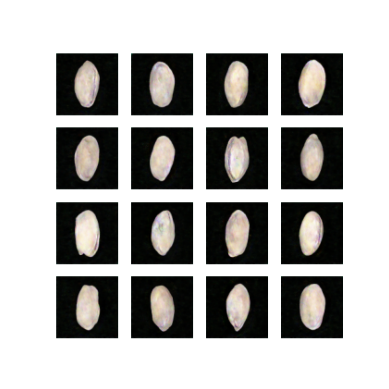

In [ ]:
def display_image(epoch_no):
  return PIL.Image.open('/content/image_results/image_epoch_{:03d}.png'.format(epoch_no))

img = display_image(1000)  #menampilkan gambar dari epoch ke 1000
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
#Lokasi file hasil
result_dir = "/content/image_results"
filenames = sorted(glob.glob(os.path.join(result_dir, 'image_epoch_*.png')))
anim_file = '/content/dcgan.gif'

#Buat GIF
if filenames:
    with imageio.get_writer(anim_file, mode='I', duration=0.5) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        #Tambahkan 1 frame akhir untuk looping
        image = imageio.imread(filenames[-1])
        writer.append_data(image)

else:
    print("Tidak ditemukan file image_epoch_*.png di folder /content/image_results/")

/tmp/ipython-input-17-2829600360.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/tmp/ipython-input-17-2829600360.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filenames[-1])



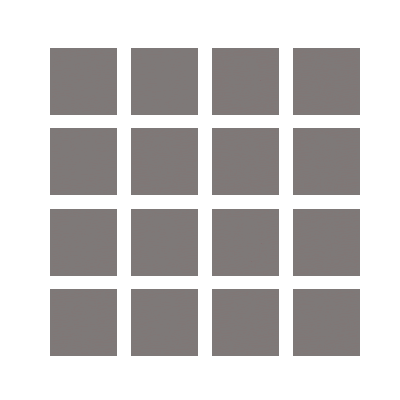

In [ ]:
embed.embed_file(anim_file)

In [ ]:
def show_real_vs_generated(generator, real_images, latent_dim=100, n=5):
    #Ambil n gambar real secara acak dari dataset
    idx = np.random.randint(0, real_images.shape[0], n)
    real_samples = real_images[idx]

    #Buat n gambar dengan noise
    noise = tf.random.normal([n, latent_dim])
    generated_samples = generator(noise, training=False)

    #Konversi hasil generator dari [-1,1] ke [0,1]
    generated_samples = 0.5 * generated_samples + 0.5

    plt.figure(figsize=(n * 2, 4))
    for i in range(n):
        #Real image
        plt.subplot(2, n, i + 1)
        plt.imshow((real_samples[i] + 1) / 2)  #Convert dari [-1, 1] ke [0,1]
        plt.axis('off')
        plt.title("Real")

        #Generated image
        plt.subplot(2, n, n + i + 1)
        plt.imshow(generated_samples[i])
        plt.axis('off')
        plt.title("Generated")

    plt.tight_layout()
    plt.show()


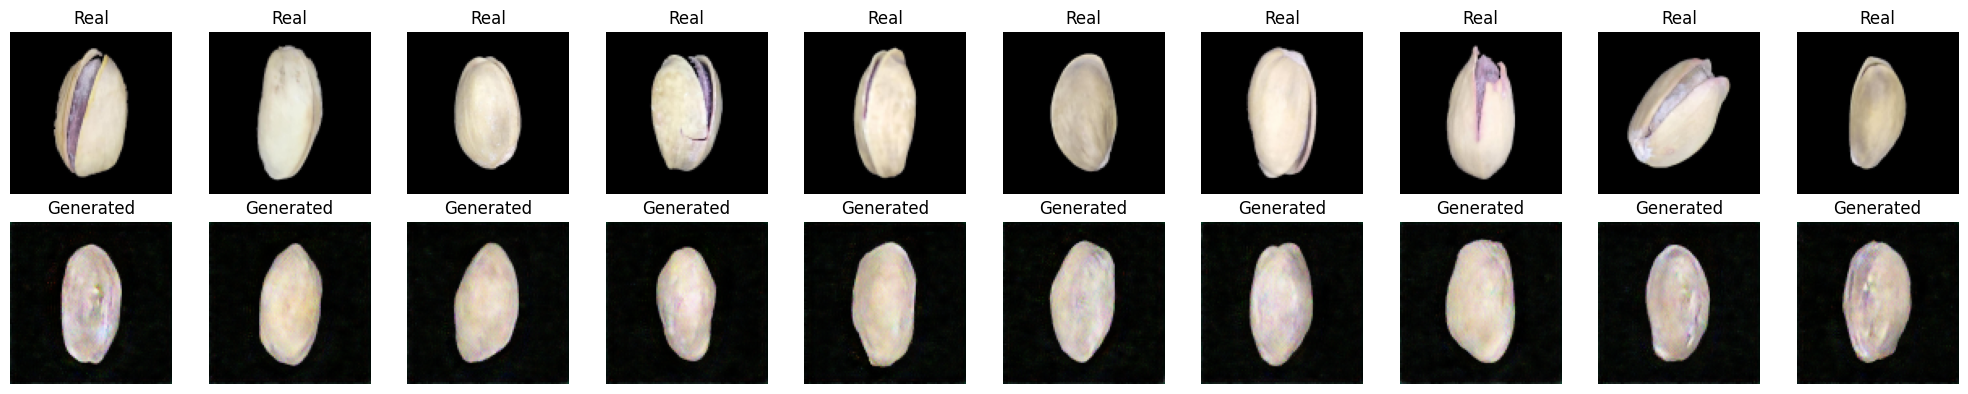

In [ ]:
show_real_vs_generated(generator, real_images, latent_dim=100, n=10)

Dapat dilihat hasil random generated dengan foto asli bisa dikatakan hampir mirip tetapi masih kekurangan detail warna (gambar atas bawah bukan berarti menandakan harus sama)

In [ ]:
def plot_gan_losses():
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.title('GAN Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

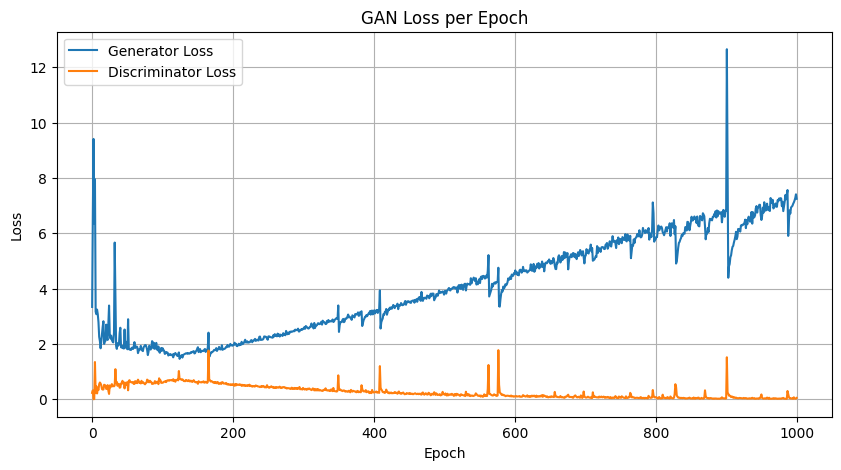

In [ ]:
plot_gan_losses()

Pada jangka panjang, discriminator meng-overpower generator (loss discriminator terlalu rendah, generator loss naik), yang menunjukkan ketidakseimbangan: Generator underfitting (tidak mampu mengejar)

#B) Tuning

In [ ]:
def build_generator_v2(latent_dim=100):
    model = tf.keras.Sequential(name="Generator_v2")
    model.add(layers.Input(shape=(latent_dim,)))
    model.add(layers.Dense(94*94*64, use_bias=False))
    model.add(layers.Reshape((94, 94, 64)))

    model.add(layers.Conv2DTranspose(64, (3,3), strides=1, padding='valid', use_bias=False))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (3,3), strides=1, padding='valid', use_bias=False))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(16, (3,3), strides=1, padding='valid', use_bias=False))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (1,1), strides=1, activation='tanh'))
    return model

generator_v2 = build_generator_v2(latent_dim)
generator_v2.summary()


Model: "Generator_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 565504)         │    56,550,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 96, 96, 64)     │        36,864 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_9              │ (None, 98, 98, 32)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 98, 98, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_10             │ (None, 100, 100, 16)   │         4,608 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 100, 100, 3)    │            51 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,610,355 (215.95 MB)

 Trainable params: 56,610,355 (215.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def build_discriminator_v2(img_shape=(100, 100, 3)):
    model = tf.keras.Sequential(name="Discriminator_v2")
    model.add(layers.Input(shape=(100, 100, 3)))

    model.add(layers.Conv2D(16, (3, 3), strides=1, padding='valid'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(32, (3, 3), strides=1, padding='valid'))
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2D(64, (3, 3), strides=1, padding='valid'))
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator_v2 = build_discriminator_v2()
discriminator_v2.summary()

Model: "Discriminator_v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_97 (Conv2D)              │ (None, 98, 98, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 98, 98, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_98 (Conv2D)              │ (None, 96, 96, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_99 (Conv2D)              │ (None, 94, 94, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 94, 94, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 565504)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │       565,505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 589,089 (2.25 MB)

 Trainable params: 589,089 (2.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
generator_optimizer_v2 = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.3)
discriminator_optimizer_v2 = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.3)

In [ ]:
cross_entropy_v2 = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def generator_loss_v2(fake_output):
    return cross_entropy_v2(tf.ones_like(fake_output), fake_output)

def discriminator_loss_v2(real_output, fake_output):
    real_loss = cross_entropy_v2(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy_v2(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

In [ ]:
def train_step_v2(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_imgs = generator_v2(noise, training=True)
        real_out = discriminator_v2(images, training=True)
        fake_out = discriminator_v2(gen_imgs,   training=True)

        g_loss = generator_loss_v2(fake_out)
        d_loss = discriminator_loss_v2(real_out, fake_out)

    grads_g = gen_tape.gradient(g_loss, generator_v2.trainable_variables)
    grads_d = disc_tape.gradient(d_loss, discriminator_v2.trainable_variables)
    generator_optimizer_v2.apply_gradients(zip(grads_g, generator_v2.trainable_variables))
    discriminator_optimizer_v2.apply_gradients(zip(grads_d, discriminator_v2.trainable_variables))
    return g_loss, d_loss

In [ ]:
def generate_and_save_images2(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = 0.5 * predictions + 0.5

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i])
        plt.axis('off')

    os.makedirs('image_results2', exist_ok=True)
    plt.savefig(f'image_results2/image_epoch_{epoch:03d}.png')
    plt.close()

In [ ]:
generator_losses_v2 = []
discriminator_losses_v2 = []

def train_v2(dataset, epochs):
    for epoch in range(epochs):
        total_g, total_d, n = 0.0, 0.0, 0
        print(f"\n[v2] Epoch {epoch+1}/{epochs}")
        for batch in tqdm(dataset, desc=f"[v2] Training Epoch {epoch+1}", leave=False):
            g_loss, d_loss = train_step_v2(batch)
            total_g += g_loss.numpy()
            total_d += d_loss.numpy()
            n += 1

        avg_g = total_g / n
        avg_d = total_d / n
        generator_losses_v2.append(avg_g)
        discriminator_losses_v2.append(avg_d)

        if (epoch + 1) % 10 == 0 or (epoch + 1) in (1, epochs):
            generate_and_save_images2(generator_v2, epoch+1, seed)
            print(f"[v2] Epoch {epoch+1} • Gen Loss: {avg_g:.4f} • Disc Loss: {avg_d:.4f}")

In [ ]:
train_v2(train_dataset, epochs=1000)


[v2] Epoch 1/1000


[v2] Epoch 1 • Gen Loss: 2.4697 • Disc Loss: 0.3409

[v2] Epoch 2/1000



[v2] Epoch 3/1000



[v2] Epoch 4/1000



[v2] Epoch 5/1000



[v2] Epoch 6/1000



[v2] Epoch 7/1000



[v2] Epoch 8/1000



[v2] Epoch 9/1000



[v2] Epoch 10/1000


[v2] Epoch 10 • Gen Loss: 1.7680 • Disc Loss: 0.7980

[v2] Epoch 11/1000



[v2] Epoch 12/1000



[v2] Epoch 13/1000



[v2] Epoch 14/1000



[v2] Epoch 15/1000



[v2] Epoch 16/1000



[v2] Epoch 17/1000



[v2] Epoch 18/1000



[v2] Epoch 19/1000



[v2] Epoch 20/1000


[v2] Epoch 20 • Gen Loss: 1.3095 • Disc Loss: 0.9914

[v2] Epoch 21/1000



[v2] Epoch 22/1000



[v2] Epoch 23/1000



[v2] Epoch 24/1000



[v2] Epoch 25/1000



[v2] Epoch 26/1000



[v2] Epoch 27/1000



[v2] Epoch 28/1000



[v2] Epoch 29/1000



[v2] Epoch 30/1000


[v2] Epoch 30 • Gen Loss: 1.2494 • Disc Loss: 0.9739

[v2] Epoch 31/1000



[v2] Epoch 32/1000



[v2] Epoch 33/1000



[v2] Epoch 34/1000



[v2] Epoch 35/1000



[v2] Epoch 36/1000



[v2] Epoch 37/1000



[v2] Epoch 38/1000



[v2] Epoch 39/1000



[v2] Epoch 40/1000


[v2] Epoch 40 • Gen Loss: 1.0608 • Disc Loss: 1.1214

[v2] Epoch 41/1000



[v2] Epoch 42/1000



[v2] Epoch 43/1000



[v2] Epoch 44/1000



[v2] Epoch 45/1000



[v2] Epoch 46/1000



[v2] Epoch 47/1000



[v2] Epoch 48/1000



[v2] Epoch 49/1000



[v2] Epoch 50/1000


[v2] Epoch 50 • Gen Loss: 1.1289 • Disc Loss: 1.1063

[v2] Epoch 51/1000



[v2] Epoch 52/1000



[v2] Epoch 53/1000



[v2] Epoch 54/1000



[v2] Epoch 55/1000



[v2] Epoch 56/1000



[v2] Epoch 57/1000



[v2] Epoch 58/1000



[v2] Epoch 59/1000



[v2] Epoch 60/1000


[v2] Epoch 60 • Gen Loss: 1.0729 • Disc Loss: 1.0613

[v2] Epoch 61/1000



[v2] Epoch 62/1000



[v2] Epoch 63/1000



[v2] Epoch 64/1000



[v2] Epoch 65/1000



[v2] Epoch 66/1000



[v2] Epoch 67/1000



[v2] Epoch 68/1000



[v2] Epoch 69/1000



[v2] Epoch 70/1000


[v2] Epoch 70 • Gen Loss: 1.1204 • Disc Loss: 1.0583

[v2] Epoch 71/1000



[v2] Epoch 72/1000



[v2] Epoch 73/1000



[v2] Epoch 74/1000



[v2] Epoch 75/1000



[v2] Epoch 76/1000



[v2] Epoch 77/1000



[v2] Epoch 78/1000



[v2] Epoch 79/1000



[v2] Epoch 80/1000


[v2] Epoch 80 • Gen Loss: 1.0495 • Disc Loss: 1.0456

[v2] Epoch 81/1000



[v2] Epoch 82/1000



[v2] Epoch 83/1000



[v2] Epoch 84/1000



[v2] Epoch 85/1000



[v2] Epoch 86/1000



[v2] Epoch 87/1000



[v2] Epoch 88/1000



[v2] Epoch 89/1000



[v2] Epoch 90/1000


[v2] Epoch 90 • Gen Loss: 1.0866 • Disc Loss: 1.0140

[v2] Epoch 91/1000



[v2] Epoch 92/1000



[v2] Epoch 93/1000



[v2] Epoch 94/1000



[v2] Epoch 95/1000



[v2] Epoch 96/1000



[v2] Epoch 97/1000



[v2] Epoch 98/1000



[v2] Epoch 99/1000



[v2] Epoch 100/1000


[v2] Epoch 100 • Gen Loss: 1.0943 • Disc Loss: 1.0241

[v2] Epoch 101/1000



[v2] Epoch 102/1000



[v2] Epoch 103/1000



[v2] Epoch 104/1000



[v2] Epoch 105/1000



[v2] Epoch 106/1000



[v2] Epoch 107/1000



[v2] Epoch 108/1000



[v2] Epoch 109/1000



[v2] Epoch 110/1000


[v2] Epoch 110 • Gen Loss: 1.1385 • Disc Loss: 1.0240

[v2] Epoch 111/1000



[v2] Epoch 112/1000



[v2] Epoch 113/1000



[v2] Epoch 114/1000



[v2] Epoch 115/1000



[v2] Epoch 116/1000



[v2] Epoch 117/1000



[v2] Epoch 118/1000



[v2] Epoch 119/1000



[v2] Epoch 120/1000


[v2] Epoch 120 • Gen Loss: 1.1404 • Disc Loss: 0.9934

[v2] Epoch 121/1000



[v2] Epoch 122/1000



[v2] Epoch 123/1000



[v2] Epoch 124/1000



[v2] Epoch 125/1000



[v2] Epoch 126/1000



[v2] Epoch 127/1000



[v2] Epoch 128/1000



[v2] Epoch 129/1000



[v2] Epoch 130/1000


[v2] Epoch 130 • Gen Loss: 1.1266 • Disc Loss: 1.0133

[v2] Epoch 131/1000



[v2] Epoch 132/1000



[v2] Epoch 133/1000



[v2] Epoch 134/1000



[v2] Epoch 135/1000



[v2] Epoch 136/1000



[v2] Epoch 137/1000



[v2] Epoch 138/1000



[v2] Epoch 139/1000



[v2] Epoch 140/1000


[v2] Epoch 140 • Gen Loss: 1.1076 • Disc Loss: 1.0234

[v2] Epoch 141/1000



[v2] Epoch 142/1000



[v2] Epoch 143/1000



[v2] Epoch 144/1000



[v2] Epoch 145/1000



[v2] Epoch 146/1000



[v2] Epoch 147/1000



[v2] Epoch 148/1000



[v2] Epoch 149/1000



[v2] Epoch 150/1000


[v2] Epoch 150 • Gen Loss: 1.0739 • Disc Loss: 1.0103

[v2] Epoch 151/1000



[v2] Epoch 152/1000



[v2] Epoch 153/1000



[v2] Epoch 154/1000



[v2] Epoch 155/1000



[v2] Epoch 156/1000



[v2] Epoch 157/1000



[v2] Epoch 158/1000



[v2] Epoch 159/1000



[v2] Epoch 160/1000


[v2] Epoch 160 • Gen Loss: 1.4207 • Disc Loss: 1.4247

[v2] Epoch 161/1000



[v2] Epoch 162/1000



[v2] Epoch 163/1000



[v2] Epoch 164/1000



[v2] Epoch 165/1000



[v2] Epoch 166/1000



[v2] Epoch 167/1000



[v2] Epoch 168/1000



[v2] Epoch 169/1000



[v2] Epoch 170/1000


[v2] Epoch 170 • Gen Loss: 1.0767 • Disc Loss: 1.0205

[v2] Epoch 171/1000



[v2] Epoch 172/1000



[v2] Epoch 173/1000



[v2] Epoch 174/1000



[v2] Epoch 175/1000



[v2] Epoch 176/1000



[v2] Epoch 177/1000



[v2] Epoch 178/1000



[v2] Epoch 179/1000



[v2] Epoch 180/1000


[v2] Epoch 180 • Gen Loss: 1.0794 • Disc Loss: 1.0566

[v2] Epoch 181/1000



[v2] Epoch 182/1000



[v2] Epoch 183/1000



[v2] Epoch 184/1000



[v2] Epoch 185/1000



[v2] Epoch 186/1000



[v2] Epoch 187/1000



[v2] Epoch 188/1000



[v2] Epoch 189/1000



[v2] Epoch 190/1000


[v2] Epoch 190 • Gen Loss: 1.0973 • Disc Loss: 1.1271

[v2] Epoch 191/1000



[v2] Epoch 192/1000



[v2] Epoch 193/1000



[v2] Epoch 194/1000



[v2] Epoch 195/1000



[v2] Epoch 196/1000



[v2] Epoch 197/1000



[v2] Epoch 198/1000



[v2] Epoch 199/1000



[v2] Epoch 200/1000


[v2] Epoch 200 • Gen Loss: 1.0870 • Disc Loss: 1.0785

[v2] Epoch 201/1000



[v2] Epoch 202/1000



[v2] Epoch 203/1000



[v2] Epoch 204/1000



[v2] Epoch 205/1000



[v2] Epoch 206/1000



[v2] Epoch 207/1000



[v2] Epoch 208/1000



[v2] Epoch 209/1000



[v2] Epoch 210/1000


[v2] Epoch 210 • Gen Loss: 0.9980 • Disc Loss: 1.0886

[v2] Epoch 211/1000



[v2] Epoch 212/1000



[v2] Epoch 213/1000



[v2] Epoch 214/1000



[v2] Epoch 215/1000



[v2] Epoch 216/1000



[v2] Epoch 217/1000



[v2] Epoch 218/1000



[v2] Epoch 219/1000



[v2] Epoch 220/1000


[v2] Epoch 220 • Gen Loss: 1.0284 • Disc Loss: 1.0920

[v2] Epoch 221/1000



[v2] Epoch 222/1000



[v2] Epoch 223/1000



[v2] Epoch 224/1000



[v2] Epoch 225/1000



[v2] Epoch 226/1000



[v2] Epoch 227/1000



[v2] Epoch 228/1000



[v2] Epoch 229/1000



[v2] Epoch 230/1000


[v2] Epoch 230 • Gen Loss: 1.0172 • Disc Loss: 1.0952

[v2] Epoch 231/1000



[v2] Epoch 232/1000



[v2] Epoch 233/1000



[v2] Epoch 234/1000



[v2] Epoch 235/1000



[v2] Epoch 236/1000



[v2] Epoch 237/1000



[v2] Epoch 238/1000



[v2] Epoch 239/1000



[v2] Epoch 240/1000


[v2] Epoch 240 • Gen Loss: 1.0037 • Disc Loss: 1.0980

[v2] Epoch 241/1000



[v2] Epoch 242/1000



[v2] Epoch 243/1000



[v2] Epoch 244/1000



[v2] Epoch 245/1000



[v2] Epoch 246/1000



[v2] Epoch 247/1000



[v2] Epoch 248/1000



[v2] Epoch 249/1000



[v2] Epoch 250/1000


[v2] Epoch 250 • Gen Loss: 1.0135 • Disc Loss: 1.0881

[v2] Epoch 251/1000



[v2] Epoch 252/1000



[v2] Epoch 253/1000



[v2] Epoch 254/1000



[v2] Epoch 255/1000



[v2] Epoch 256/1000



[v2] Epoch 257/1000



[v2] Epoch 258/1000



[v2] Epoch 259/1000



[v2] Epoch 260/1000


[v2] Epoch 260 • Gen Loss: 1.0302 • Disc Loss: 1.1117

[v2] Epoch 261/1000



[v2] Epoch 262/1000



[v2] Epoch 263/1000



[v2] Epoch 264/1000



[v2] Epoch 265/1000



[v2] Epoch 266/1000



[v2] Epoch 267/1000



[v2] Epoch 268/1000



[v2] Epoch 269/1000



[v2] Epoch 270/1000


[v2] Epoch 270 • Gen Loss: 0.9968 • Disc Loss: 1.0923

[v2] Epoch 271/1000



[v2] Epoch 272/1000



[v2] Epoch 273/1000



[v2] Epoch 274/1000



[v2] Epoch 275/1000



[v2] Epoch 276/1000



[v2] Epoch 277/1000



[v2] Epoch 278/1000



[v2] Epoch 279/1000



[v2] Epoch 280/1000


[v2] Epoch 280 • Gen Loss: 1.0110 • Disc Loss: 1.1139

[v2] Epoch 281/1000



[v2] Epoch 282/1000



[v2] Epoch 283/1000



[v2] Epoch 284/1000



[v2] Epoch 285/1000



[v2] Epoch 286/1000



[v2] Epoch 287/1000



[v2] Epoch 288/1000



[v2] Epoch 289/1000



[v2] Epoch 290/1000


[v2] Epoch 290 • Gen Loss: 1.0085 • Disc Loss: 1.1026

[v2] Epoch 291/1000



[v2] Epoch 292/1000



[v2] Epoch 293/1000



[v2] Epoch 294/1000



[v2] Epoch 295/1000



[v2] Epoch 296/1000



[v2] Epoch 297/1000



[v2] Epoch 298/1000



[v2] Epoch 299/1000



[v2] Epoch 300/1000


[v2] Epoch 300 • Gen Loss: 1.0649 • Disc Loss: 1.0936

[v2] Epoch 301/1000



[v2] Epoch 302/1000



[v2] Epoch 303/1000



[v2] Epoch 304/1000



[v2] Epoch 305/1000



[v2] Epoch 306/1000



[v2] Epoch 307/1000



[v2] Epoch 308/1000



[v2] Epoch 309/1000



[v2] Epoch 310/1000


[v2] Epoch 310 • Gen Loss: 1.0138 • Disc Loss: 1.1132

[v2] Epoch 311/1000



[v2] Epoch 312/1000



[v2] Epoch 313/1000



[v2] Epoch 314/1000



[v2] Epoch 315/1000



[v2] Epoch 316/1000



[v2] Epoch 317/1000



[v2] Epoch 318/1000



[v2] Epoch 319/1000



[v2] Epoch 320/1000


[v2] Epoch 320 • Gen Loss: 1.0707 • Disc Loss: 1.1753

[v2] Epoch 321/1000



[v2] Epoch 322/1000



[v2] Epoch 323/1000



[v2] Epoch 324/1000



[v2] Epoch 325/1000



[v2] Epoch 326/1000



[v2] Epoch 327/1000



[v2] Epoch 328/1000



[v2] Epoch 329/1000



[v2] Epoch 330/1000


[v2] Epoch 330 • Gen Loss: 1.0308 • Disc Loss: 1.0793

[v2] Epoch 331/1000



[v2] Epoch 332/1000



[v2] Epoch 333/1000



[v2] Epoch 334/1000



[v2] Epoch 335/1000



[v2] Epoch 336/1000



[v2] Epoch 337/1000



[v2] Epoch 338/1000



[v2] Epoch 339/1000



[v2] Epoch 340/1000


[v2] Epoch 340 • Gen Loss: 1.0169 • Disc Loss: 1.0905

[v2] Epoch 341/1000



[v2] Epoch 342/1000



[v2] Epoch 343/1000



[v2] Epoch 344/1000



[v2] Epoch 345/1000



[v2] Epoch 346/1000



[v2] Epoch 347/1000



[v2] Epoch 348/1000



[v2] Epoch 349/1000



[v2] Epoch 350/1000


[v2] Epoch 350 • Gen Loss: 1.0121 • Disc Loss: 1.1019

[v2] Epoch 351/1000



[v2] Epoch 352/1000



[v2] Epoch 353/1000



[v2] Epoch 354/1000



[v2] Epoch 355/1000



[v2] Epoch 356/1000



[v2] Epoch 357/1000



[v2] Epoch 358/1000



[v2] Epoch 359/1000



[v2] Epoch 360/1000


[v2] Epoch 360 • Gen Loss: 1.0337 • Disc Loss: 1.0888

[v2] Epoch 361/1000



[v2] Epoch 362/1000



[v2] Epoch 363/1000



[v2] Epoch 364/1000



[v2] Epoch 365/1000



[v2] Epoch 366/1000



[v2] Epoch 367/1000



[v2] Epoch 368/1000



[v2] Epoch 369/1000



[v2] Epoch 370/1000


[v2] Epoch 370 • Gen Loss: 1.0318 • Disc Loss: 1.1176

[v2] Epoch 371/1000



[v2] Epoch 372/1000



[v2] Epoch 373/1000



[v2] Epoch 374/1000



[v2] Epoch 375/1000



[v2] Epoch 376/1000



[v2] Epoch 377/1000



[v2] Epoch 378/1000



[v2] Epoch 379/1000



[v2] Epoch 380/1000


[v2] Epoch 380 • Gen Loss: 1.5634 • Disc Loss: 1.5411

[v2] Epoch 381/1000



[v2] Epoch 382/1000



[v2] Epoch 383/1000



[v2] Epoch 384/1000



[v2] Epoch 385/1000



[v2] Epoch 386/1000



[v2] Epoch 387/1000



[v2] Epoch 388/1000



[v2] Epoch 389/1000



[v2] Epoch 390/1000


[v2] Epoch 390 • Gen Loss: 1.0105 • Disc Loss: 1.0590

[v2] Epoch 391/1000



[v2] Epoch 392/1000



[v2] Epoch 393/1000



[v2] Epoch 394/1000



[v2] Epoch 395/1000



[v2] Epoch 396/1000



[v2] Epoch 397/1000



[v2] Epoch 398/1000



[v2] Epoch 399/1000



[v2] Epoch 400/1000


[v2] Epoch 400 • Gen Loss: 1.0380 • Disc Loss: 1.0711

[v2] Epoch 401/1000



[v2] Epoch 402/1000



[v2] Epoch 403/1000



[v2] Epoch 404/1000



[v2] Epoch 405/1000



[v2] Epoch 406/1000



[v2] Epoch 407/1000



[v2] Epoch 408/1000



[v2] Epoch 409/1000



[v2] Epoch 410/1000


[v2] Epoch 410 • Gen Loss: 1.0386 • Disc Loss: 1.0506

[v2] Epoch 411/1000



[v2] Epoch 412/1000



[v2] Epoch 413/1000



[v2] Epoch 414/1000



[v2] Epoch 415/1000



[v2] Epoch 416/1000



[v2] Epoch 417/1000



[v2] Epoch 418/1000



[v2] Epoch 419/1000



[v2] Epoch 420/1000


[v2] Epoch 420 • Gen Loss: 1.0568 • Disc Loss: 1.0698

[v2] Epoch 421/1000



[v2] Epoch 422/1000



[v2] Epoch 423/1000



[v2] Epoch 424/1000



[v2] Epoch 425/1000



[v2] Epoch 426/1000



[v2] Epoch 427/1000



[v2] Epoch 428/1000



[v2] Epoch 429/1000



[v2] Epoch 430/1000


[v2] Epoch 430 • Gen Loss: 2.5414 • Disc Loss: 2.5643

[v2] Epoch 431/1000



[v2] Epoch 432/1000



[v2] Epoch 433/1000



[v2] Epoch 434/1000



[v2] Epoch 435/1000



[v2] Epoch 436/1000



[v2] Epoch 437/1000



[v2] Epoch 438/1000



[v2] Epoch 439/1000



[v2] Epoch 440/1000


[v2] Epoch 440 • Gen Loss: 1.0479 • Disc Loss: 1.0704

[v2] Epoch 441/1000



[v2] Epoch 442/1000



[v2] Epoch 443/1000



[v2] Epoch 444/1000



[v2] Epoch 445/1000



[v2] Epoch 446/1000



[v2] Epoch 447/1000



[v2] Epoch 448/1000



[v2] Epoch 449/1000



[v2] Epoch 450/1000


[v2] Epoch 450 • Gen Loss: 1.0772 • Disc Loss: 1.0475

[v2] Epoch 451/1000



[v2] Epoch 452/1000



[v2] Epoch 453/1000



[v2] Epoch 454/1000



[v2] Epoch 455/1000



[v2] Epoch 456/1000



[v2] Epoch 457/1000



[v2] Epoch 458/1000



[v2] Epoch 459/1000



[v2] Epoch 460/1000


[v2] Epoch 460 • Gen Loss: 1.0590 • Disc Loss: 1.0485

[v2] Epoch 461/1000



[v2] Epoch 462/1000



[v2] Epoch 463/1000



[v2] Epoch 464/1000



[v2] Epoch 465/1000



[v2] Epoch 466/1000



[v2] Epoch 467/1000



[v2] Epoch 468/1000



[v2] Epoch 469/1000



[v2] Epoch 470/1000


[v2] Epoch 470 • Gen Loss: 1.1044 • Disc Loss: 1.0615

[v2] Epoch 471/1000



[v2] Epoch 472/1000



[v2] Epoch 473/1000



[v2] Epoch 474/1000



[v2] Epoch 475/1000



[v2] Epoch 476/1000



[v2] Epoch 477/1000



[v2] Epoch 478/1000



[v2] Epoch 479/1000



[v2] Epoch 480/1000


[v2] Epoch 480 • Gen Loss: 1.1050 • Disc Loss: 1.0234

[v2] Epoch 481/1000



[v2] Epoch 482/1000



[v2] Epoch 483/1000



[v2] Epoch 484/1000



[v2] Epoch 485/1000



[v2] Epoch 486/1000



[v2] Epoch 487/1000



[v2] Epoch 488/1000



[v2] Epoch 489/1000



[v2] Epoch 490/1000


[v2] Epoch 490 • Gen Loss: 1.0201 • Disc Loss: 1.0636

[v2] Epoch 491/1000



[v2] Epoch 492/1000



[v2] Epoch 493/1000



[v2] Epoch 494/1000



[v2] Epoch 495/1000



[v2] Epoch 496/1000



[v2] Epoch 497/1000



[v2] Epoch 498/1000



[v2] Epoch 499/1000



[v2] Epoch 500/1000


[v2] Epoch 500 • Gen Loss: 1.0875 • Disc Loss: 0.9914

[v2] Epoch 501/1000



[v2] Epoch 502/1000



[v2] Epoch 503/1000



[v2] Epoch 504/1000



[v2] Epoch 505/1000



[v2] Epoch 506/1000



[v2] Epoch 507/1000



[v2] Epoch 508/1000



[v2] Epoch 509/1000



[v2] Epoch 510/1000


[v2] Epoch 510 • Gen Loss: 1.1163 • Disc Loss: 1.0216

[v2] Epoch 511/1000



[v2] Epoch 512/1000



[v2] Epoch 513/1000



[v2] Epoch 514/1000



[v2] Epoch 515/1000



[v2] Epoch 516/1000



[v2] Epoch 517/1000



[v2] Epoch 518/1000



[v2] Epoch 519/1000



[v2] Epoch 520/1000


[v2] Epoch 520 • Gen Loss: 1.1099 • Disc Loss: 1.0166

[v2] Epoch 521/1000



[v2] Epoch 522/1000



[v2] Epoch 523/1000



[v2] Epoch 524/1000



[v2] Epoch 525/1000



[v2] Epoch 526/1000



[v2] Epoch 527/1000



[v2] Epoch 528/1000



[v2] Epoch 529/1000



[v2] Epoch 530/1000


[v2] Epoch 530 • Gen Loss: 1.1344 • Disc Loss: 1.0083

[v2] Epoch 531/1000



[v2] Epoch 532/1000



[v2] Epoch 533/1000



[v2] Epoch 534/1000



[v2] Epoch 535/1000



[v2] Epoch 536/1000



[v2] Epoch 537/1000



[v2] Epoch 538/1000



[v2] Epoch 539/1000



[v2] Epoch 540/1000


[v2] Epoch 540 • Gen Loss: 1.1335 • Disc Loss: 1.0051

[v2] Epoch 541/1000



[v2] Epoch 542/1000



[v2] Epoch 543/1000



[v2] Epoch 544/1000



[v2] Epoch 545/1000



[v2] Epoch 546/1000



[v2] Epoch 547/1000



[v2] Epoch 548/1000



[v2] Epoch 549/1000



[v2] Epoch 550/1000


[v2] Epoch 550 • Gen Loss: 1.1070 • Disc Loss: 1.0062

[v2] Epoch 551/1000



[v2] Epoch 552/1000



[v2] Epoch 553/1000



[v2] Epoch 554/1000



[v2] Epoch 555/1000



[v2] Epoch 556/1000



[v2] Epoch 557/1000



[v2] Epoch 558/1000



[v2] Epoch 559/1000



[v2] Epoch 560/1000


[v2] Epoch 560 • Gen Loss: 1.1534 • Disc Loss: 0.9919

[v2] Epoch 561/1000



[v2] Epoch 562/1000



[v2] Epoch 563/1000



[v2] Epoch 564/1000



[v2] Epoch 565/1000



[v2] Epoch 566/1000



[v2] Epoch 567/1000



[v2] Epoch 568/1000



[v2] Epoch 569/1000



[v2] Epoch 570/1000


[v2] Epoch 570 • Gen Loss: 1.1919 • Disc Loss: 0.9982

[v2] Epoch 571/1000



[v2] Epoch 572/1000



[v2] Epoch 573/1000



[v2] Epoch 574/1000



[v2] Epoch 575/1000



[v2] Epoch 576/1000



[v2] Epoch 577/1000



[v2] Epoch 578/1000



[v2] Epoch 579/1000



[v2] Epoch 580/1000


[v2] Epoch 580 • Gen Loss: 1.1873 • Disc Loss: 0.9637

[v2] Epoch 581/1000



[v2] Epoch 582/1000



[v2] Epoch 583/1000



[v2] Epoch 584/1000



[v2] Epoch 585/1000



[v2] Epoch 586/1000



[v2] Epoch 587/1000



[v2] Epoch 588/1000



[v2] Epoch 589/1000



[v2] Epoch 590/1000


[v2] Epoch 590 • Gen Loss: 1.2186 • Disc Loss: 0.9713

[v2] Epoch 591/1000



[v2] Epoch 592/1000



[v2] Epoch 593/1000



[v2] Epoch 594/1000



[v2] Epoch 595/1000



[v2] Epoch 596/1000



[v2] Epoch 597/1000



[v2] Epoch 598/1000



[v2] Epoch 599/1000



[v2] Epoch 600/1000


[v2] Epoch 600 • Gen Loss: 1.1938 • Disc Loss: 0.9613

[v2] Epoch 601/1000



[v2] Epoch 602/1000



[v2] Epoch 603/1000



[v2] Epoch 604/1000



[v2] Epoch 605/1000



[v2] Epoch 606/1000



[v2] Epoch 607/1000



[v2] Epoch 608/1000



[v2] Epoch 609/1000



[v2] Epoch 610/1000


[v2] Epoch 610 • Gen Loss: 1.1822 • Disc Loss: 0.9754

[v2] Epoch 611/1000



[v2] Epoch 612/1000



[v2] Epoch 613/1000



[v2] Epoch 614/1000



[v2] Epoch 615/1000



[v2] Epoch 616/1000



[v2] Epoch 617/1000



[v2] Epoch 618/1000



[v2] Epoch 619/1000



[v2] Epoch 620/1000


[v2] Epoch 620 • Gen Loss: 1.2177 • Disc Loss: 0.9057

[v2] Epoch 621/1000



[v2] Epoch 622/1000



[v2] Epoch 623/1000



[v2] Epoch 624/1000



[v2] Epoch 625/1000



[v2] Epoch 626/1000



[v2] Epoch 627/1000



[v2] Epoch 628/1000



[v2] Epoch 629/1000



[v2] Epoch 630/1000


[v2] Epoch 630 • Gen Loss: 1.2286 • Disc Loss: 0.9918

[v2] Epoch 631/1000



[v2] Epoch 632/1000



[v2] Epoch 633/1000



[v2] Epoch 634/1000



[v2] Epoch 635/1000



[v2] Epoch 636/1000



[v2] Epoch 637/1000



[v2] Epoch 638/1000



[v2] Epoch 639/1000



[v2] Epoch 640/1000


[v2] Epoch 640 • Gen Loss: 1.2459 • Disc Loss: 0.9183

[v2] Epoch 641/1000



[v2] Epoch 642/1000



[v2] Epoch 643/1000



[v2] Epoch 644/1000



[v2] Epoch 645/1000



[v2] Epoch 646/1000



[v2] Epoch 647/1000



[v2] Epoch 648/1000



[v2] Epoch 649/1000



[v2] Epoch 650/1000


[v2] Epoch 650 • Gen Loss: 1.2306 • Disc Loss: 0.9261

[v2] Epoch 651/1000



[v2] Epoch 652/1000



[v2] Epoch 653/1000



[v2] Epoch 654/1000



[v2] Epoch 655/1000



[v2] Epoch 656/1000



[v2] Epoch 657/1000



[v2] Epoch 658/1000



[v2] Epoch 659/1000



[v2] Epoch 660/1000


[v2] Epoch 660 • Gen Loss: 1.2522 • Disc Loss: 0.9262

[v2] Epoch 661/1000



[v2] Epoch 662/1000



[v2] Epoch 663/1000



[v2] Epoch 664/1000



[v2] Epoch 665/1000



[v2] Epoch 666/1000



[v2] Epoch 667/1000



[v2] Epoch 668/1000



[v2] Epoch 669/1000



[v2] Epoch 670/1000


[v2] Epoch 670 • Gen Loss: 1.1869 • Disc Loss: 0.9970

[v2] Epoch 671/1000



[v2] Epoch 672/1000



[v2] Epoch 673/1000



[v2] Epoch 674/1000



[v2] Epoch 675/1000



[v2] Epoch 676/1000



[v2] Epoch 677/1000



[v2] Epoch 678/1000



[v2] Epoch 679/1000



[v2] Epoch 680/1000


[v2] Epoch 680 • Gen Loss: 1.2582 • Disc Loss: 0.8971

[v2] Epoch 681/1000



[v2] Epoch 682/1000



[v2] Epoch 683/1000



[v2] Epoch 684/1000



[v2] Epoch 685/1000



[v2] Epoch 686/1000



[v2] Epoch 687/1000



[v2] Epoch 688/1000



[v2] Epoch 689/1000



[v2] Epoch 690/1000


[v2] Epoch 690 • Gen Loss: 1.2939 • Disc Loss: 0.8794

[v2] Epoch 691/1000



[v2] Epoch 692/1000



[v2] Epoch 693/1000



[v2] Epoch 694/1000



[v2] Epoch 695/1000



[v2] Epoch 696/1000



[v2] Epoch 697/1000



[v2] Epoch 698/1000



[v2] Epoch 699/1000



[v2] Epoch 700/1000


[v2] Epoch 700 • Gen Loss: 1.2940 • Disc Loss: 0.8641

[v2] Epoch 701/1000



[v2] Epoch 702/1000



[v2] Epoch 703/1000



[v2] Epoch 704/1000



[v2] Epoch 705/1000



[v2] Epoch 706/1000



[v2] Epoch 707/1000



[v2] Epoch 708/1000



[v2] Epoch 709/1000



[v2] Epoch 710/1000


[v2] Epoch 710 • Gen Loss: 1.3325 • Disc Loss: 0.8906

[v2] Epoch 711/1000



[v2] Epoch 712/1000



[v2] Epoch 713/1000



[v2] Epoch 714/1000



[v2] Epoch 715/1000



[v2] Epoch 716/1000



[v2] Epoch 717/1000



[v2] Epoch 718/1000



[v2] Epoch 719/1000



[v2] Epoch 720/1000


[v2] Epoch 720 • Gen Loss: 1.3074 • Disc Loss: 0.8371

[v2] Epoch 721/1000



[v2] Epoch 722/1000



[v2] Epoch 723/1000



[v2] Epoch 724/1000



[v2] Epoch 725/1000



[v2] Epoch 726/1000



[v2] Epoch 727/1000



[v2] Epoch 728/1000



[v2] Epoch 729/1000



[v2] Epoch 730/1000


[v2] Epoch 730 • Gen Loss: 1.3577 • Disc Loss: 0.8438

[v2] Epoch 731/1000



[v2] Epoch 732/1000



[v2] Epoch 733/1000



[v2] Epoch 734/1000



[v2] Epoch 735/1000



[v2] Epoch 736/1000



[v2] Epoch 737/1000



[v2] Epoch 738/1000



[v2] Epoch 739/1000



[v2] Epoch 740/1000


[v2] Epoch 740 • Gen Loss: 1.3506 • Disc Loss: 0.9039

[v2] Epoch 741/1000



[v2] Epoch 742/1000



[v2] Epoch 743/1000



[v2] Epoch 744/1000



[v2] Epoch 745/1000



[v2] Epoch 746/1000



[v2] Epoch 747/1000



[v2] Epoch 748/1000



[v2] Epoch 749/1000



[v2] Epoch 750/1000


[v2] Epoch 750 • Gen Loss: 1.4364 • Disc Loss: 0.8920

[v2] Epoch 751/1000



[v2] Epoch 752/1000



[v2] Epoch 753/1000



[v2] Epoch 754/1000



[v2] Epoch 755/1000



[v2] Epoch 756/1000



[v2] Epoch 757/1000



[v2] Epoch 758/1000



[v2] Epoch 759/1000



[v2] Epoch 760/1000


[v2] Epoch 760 • Gen Loss: 1.3635 • Disc Loss: 0.8458

[v2] Epoch 761/1000



[v2] Epoch 762/1000



[v2] Epoch 763/1000



[v2] Epoch 764/1000



[v2] Epoch 765/1000



[v2] Epoch 766/1000



[v2] Epoch 767/1000



[v2] Epoch 768/1000



[v2] Epoch 769/1000



[v2] Epoch 770/1000


[v2] Epoch 770 • Gen Loss: 1.4023 • Disc Loss: 0.8357

[v2] Epoch 771/1000



[v2] Epoch 772/1000



[v2] Epoch 773/1000



[v2] Epoch 774/1000



[v2] Epoch 775/1000



[v2] Epoch 776/1000



[v2] Epoch 777/1000



[v2] Epoch 778/1000



[v2] Epoch 779/1000



[v2] Epoch 780/1000


[v2] Epoch 780 • Gen Loss: 1.4679 • Disc Loss: 0.8781

[v2] Epoch 781/1000



[v2] Epoch 782/1000



[v2] Epoch 783/1000



[v2] Epoch 784/1000



[v2] Epoch 785/1000



[v2] Epoch 786/1000



[v2] Epoch 787/1000



[v2] Epoch 788/1000



[v2] Epoch 789/1000



[v2] Epoch 790/1000


[v2] Epoch 790 • Gen Loss: 1.4184 • Disc Loss: 0.7859

[v2] Epoch 791/1000



[v2] Epoch 792/1000



[v2] Epoch 793/1000



[v2] Epoch 794/1000



[v2] Epoch 795/1000



[v2] Epoch 796/1000



[v2] Epoch 797/1000



[v2] Epoch 798/1000



[v2] Epoch 799/1000



[v2] Epoch 800/1000


[v2] Epoch 800 • Gen Loss: 1.4257 • Disc Loss: 0.8635

[v2] Epoch 801/1000



[v2] Epoch 802/1000



[v2] Epoch 803/1000



[v2] Epoch 804/1000



[v2] Epoch 805/1000



[v2] Epoch 806/1000



[v2] Epoch 807/1000



[v2] Epoch 808/1000



[v2] Epoch 809/1000



[v2] Epoch 810/1000


[v2] Epoch 810 • Gen Loss: 1.4015 • Disc Loss: 0.7911

[v2] Epoch 811/1000



[v2] Epoch 812/1000



[v2] Epoch 813/1000



[v2] Epoch 814/1000



[v2] Epoch 815/1000



[v2] Epoch 816/1000



[v2] Epoch 817/1000



[v2] Epoch 818/1000



[v2] Epoch 819/1000



[v2] Epoch 820/1000


[v2] Epoch 820 • Gen Loss: 1.4442 • Disc Loss: 0.7660

[v2] Epoch 821/1000



[v2] Epoch 822/1000



[v2] Epoch 823/1000



[v2] Epoch 824/1000



[v2] Epoch 825/1000



[v2] Epoch 826/1000



[v2] Epoch 827/1000



[v2] Epoch 828/1000



[v2] Epoch 829/1000



[v2] Epoch 830/1000


[v2] Epoch 830 • Gen Loss: 1.5903 • Disc Loss: 0.9656

[v2] Epoch 831/1000



[v2] Epoch 832/1000



[v2] Epoch 833/1000



[v2] Epoch 834/1000



[v2] Epoch 835/1000



[v2] Epoch 836/1000



[v2] Epoch 837/1000



[v2] Epoch 838/1000



[v2] Epoch 839/1000



[v2] Epoch 840/1000


[v2] Epoch 840 • Gen Loss: 1.5105 • Disc Loss: 0.8176

[v2] Epoch 841/1000



[v2] Epoch 842/1000



[v2] Epoch 843/1000



[v2] Epoch 844/1000



[v2] Epoch 845/1000



[v2] Epoch 846/1000



[v2] Epoch 847/1000



[v2] Epoch 848/1000



[v2] Epoch 849/1000



[v2] Epoch 850/1000


[v2] Epoch 850 • Gen Loss: 1.5167 • Disc Loss: 0.8069

[v2] Epoch 851/1000



[v2] Epoch 852/1000



[v2] Epoch 853/1000



[v2] Epoch 854/1000



[v2] Epoch 855/1000



[v2] Epoch 856/1000



[v2] Epoch 857/1000



[v2] Epoch 858/1000



[v2] Epoch 859/1000



[v2] Epoch 860/1000


[v2] Epoch 860 • Gen Loss: 1.5424 • Disc Loss: 0.7710

[v2] Epoch 861/1000



[v2] Epoch 862/1000



[v2] Epoch 863/1000



[v2] Epoch 864/1000



[v2] Epoch 865/1000



[v2] Epoch 866/1000



[v2] Epoch 867/1000



[v2] Epoch 868/1000



[v2] Epoch 869/1000



[v2] Epoch 870/1000


[v2] Epoch 870 • Gen Loss: 2.8890 • Disc Loss: 2.8354

[v2] Epoch 871/1000



[v2] Epoch 872/1000



[v2] Epoch 873/1000



[v2] Epoch 874/1000



[v2] Epoch 875/1000



[v2] Epoch 876/1000



[v2] Epoch 877/1000



[v2] Epoch 878/1000



[v2] Epoch 879/1000



[v2] Epoch 880/1000


[v2] Epoch 880 • Gen Loss: 1.5447 • Disc Loss: 0.7683

[v2] Epoch 881/1000



[v2] Epoch 882/1000



[v2] Epoch 883/1000



[v2] Epoch 884/1000



[v2] Epoch 885/1000



[v2] Epoch 886/1000



[v2] Epoch 887/1000



[v2] Epoch 888/1000



[v2] Epoch 889/1000



[v2] Epoch 890/1000


[v2] Epoch 890 • Gen Loss: 1.5704 • Disc Loss: 0.7724

[v2] Epoch 891/1000



[v2] Epoch 892/1000



[v2] Epoch 893/1000



[v2] Epoch 894/1000



[v2] Epoch 895/1000



[v2] Epoch 896/1000



[v2] Epoch 897/1000



[v2] Epoch 898/1000



[v2] Epoch 899/1000



[v2] Epoch 900/1000


[v2] Epoch 900 • Gen Loss: 1.5705 • Disc Loss: 0.7827

[v2] Epoch 901/1000



[v2] Epoch 902/1000



[v2] Epoch 903/1000



[v2] Epoch 904/1000



[v2] Epoch 905/1000



[v2] Epoch 906/1000



[v2] Epoch 907/1000



[v2] Epoch 908/1000



[v2] Epoch 909/1000



[v2] Epoch 910/1000


[v2] Epoch 910 • Gen Loss: 1.6287 • Disc Loss: 0.7764

[v2] Epoch 911/1000



[v2] Epoch 912/1000



[v2] Epoch 913/1000



[v2] Epoch 914/1000



[v2] Epoch 915/1000



[v2] Epoch 916/1000



[v2] Epoch 917/1000



[v2] Epoch 918/1000



[v2] Epoch 919/1000



[v2] Epoch 920/1000


[v2] Epoch 920 • Gen Loss: 1.6069 • Disc Loss: 0.7282

[v2] Epoch 921/1000



[v2] Epoch 922/1000



[v2] Epoch 923/1000



[v2] Epoch 924/1000



[v2] Epoch 925/1000



[v2] Epoch 926/1000



[v2] Epoch 927/1000



[v2] Epoch 928/1000



[v2] Epoch 929/1000



[v2] Epoch 930/1000


[v2] Epoch 930 • Gen Loss: 1.6597 • Disc Loss: 0.7089

[v2] Epoch 931/1000



[v2] Epoch 932/1000



[v2] Epoch 933/1000



[v2] Epoch 934/1000



[v2] Epoch 935/1000



[v2] Epoch 936/1000



[v2] Epoch 937/1000



[v2] Epoch 938/1000



[v2] Epoch 939/1000



[v2] Epoch 940/1000


[v2] Epoch 940 • Gen Loss: 1.6432 • Disc Loss: 0.7340

[v2] Epoch 941/1000



[v2] Epoch 942/1000



[v2] Epoch 943/1000



[v2] Epoch 944/1000



[v2] Epoch 945/1000



[v2] Epoch 946/1000



[v2] Epoch 947/1000



[v2] Epoch 948/1000



[v2] Epoch 949/1000



[v2] Epoch 950/1000


[v2] Epoch 950 • Gen Loss: 1.7008 • Disc Loss: 0.7517

[v2] Epoch 951/1000



[v2] Epoch 952/1000



[v2] Epoch 953/1000



[v2] Epoch 954/1000



[v2] Epoch 955/1000



[v2] Epoch 956/1000



[v2] Epoch 957/1000



[v2] Epoch 958/1000



[v2] Epoch 959/1000



[v2] Epoch 960/1000


[v2] Epoch 960 • Gen Loss: 1.7068 • Disc Loss: 0.6919

[v2] Epoch 961/1000



[v2] Epoch 962/1000



[v2] Epoch 963/1000



[v2] Epoch 964/1000



[v2] Epoch 965/1000



[v2] Epoch 966/1000



[v2] Epoch 967/1000



[v2] Epoch 968/1000



[v2] Epoch 969/1000



[v2] Epoch 970/1000


[v2] Epoch 970 • Gen Loss: 1.5008 • Disc Loss: 0.7620

[v2] Epoch 971/1000



[v2] Epoch 972/1000



[v2] Epoch 973/1000



[v2] Epoch 974/1000



[v2] Epoch 975/1000



[v2] Epoch 976/1000



[v2] Epoch 977/1000



[v2] Epoch 978/1000



[v2] Epoch 979/1000



[v2] Epoch 980/1000


[v2] Epoch 980 • Gen Loss: 1.6142 • Disc Loss: 0.6686

[v2] Epoch 981/1000



[v2] Epoch 982/1000



[v2] Epoch 983/1000



[v2] Epoch 984/1000



[v2] Epoch 985/1000



[v2] Epoch 986/1000



[v2] Epoch 987/1000



[v2] Epoch 988/1000



[v2] Epoch 989/1000



[v2] Epoch 990/1000


[v2] Epoch 990 • Gen Loss: 1.7299 • Disc Loss: 0.6594

[v2] Epoch 991/1000



[v2] Epoch 992/1000



[v2] Epoch 993/1000



[v2] Epoch 994/1000



[v2] Epoch 995/1000



[v2] Epoch 996/1000



[v2] Epoch 997/1000



[v2] Epoch 998/1000



[v2] Epoch 999/1000



[v2] Epoch 1000/1000


[v2] Epoch 1000 • Gen Loss: 1.7639 • Disc Loss: 0.7024


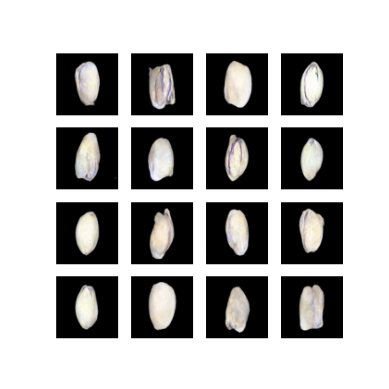

In [ ]:
def display_imageV2(epoch_no):
  return PIL.Image.open('/content/image_results2/image_epoch_{:03d}.png'.format(epoch_no))

img = display_imageV2(1000)
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
#Lokasi file hasil model v2
result_dir_v2 = "/content/image_results2"
filenames_v2 = sorted(glob.glob(os.path.join(result_dir_v2, 'image_epoch_*.png')))
anim_file_v2 = '/content/dcgan_v2.gif'

#Buat GIF untuk model v2
if filenames_v2:
    with imageio.get_writer(anim_file_v2, mode='I', duration=0.5) as writer:
        for fname in filenames_v2:
            img = imageio.imread(fname)
            writer.append_data(img)
        img = imageio.imread(filenames_v2[-1])
        writer.append_data(img)
else:
    print("Tidak ditemukan file image_epoch_*.png di folder /content/image_results2/")


/tmp/ipython-input-35-1172846997.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fname)
/tmp/ipython-input-35-1172846997.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filenames_v2[-1])



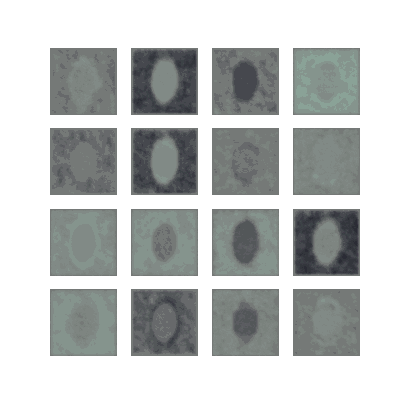

In [ ]:
embed.embed_file(anim_file_v2)

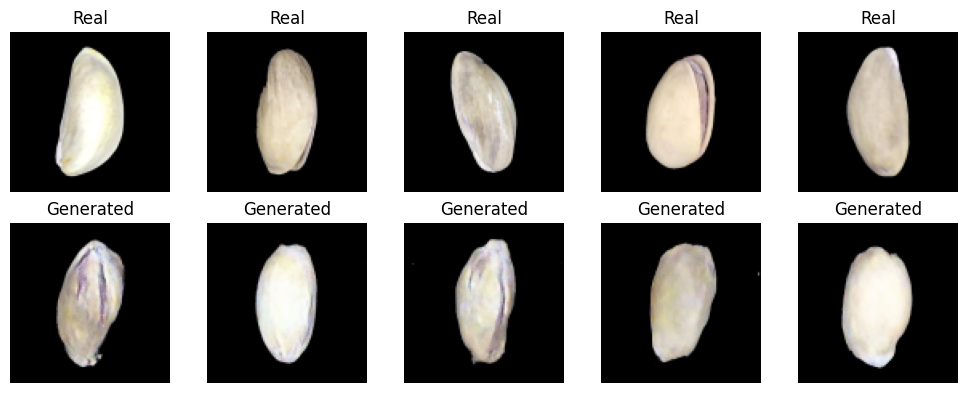

In [ ]:
show_real_vs_generated(generator_v2, real_images, latent_dim=100, n=5)

Dapat dilihat hasil random generated dengan foto asli bisa dikatakan hampir mirip (gambar atas bawah bukan berarti menandakan harus sama)

In [ ]:
def plot_loss_v2():
    plt.figure(figsize=(10,6))
    plt.plot(generator_losses_v2, label='Generator Loss v2')
    plt.plot(discriminator_losses_v2, label='Discriminator Loss v2')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("GAN Loss (v2)")
    plt.legend()
    plt.grid(True)
    plt.show()

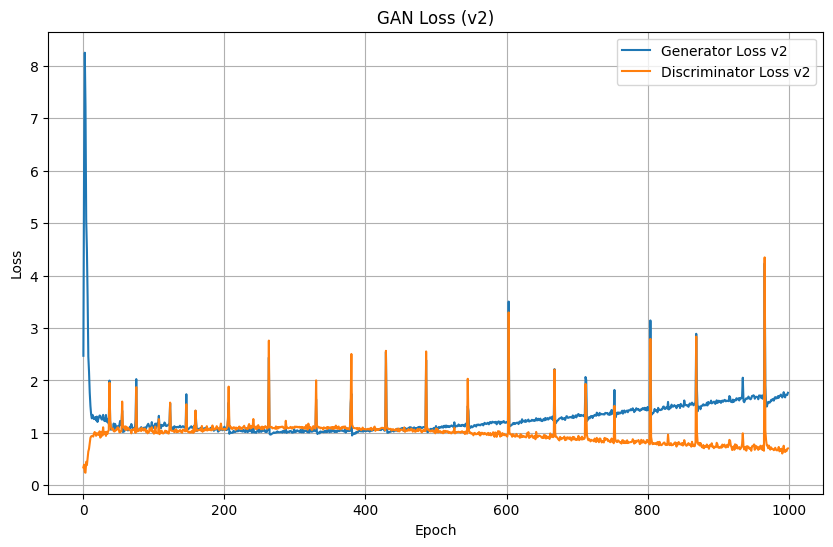

In [ ]:
plot_loss_v2()

Generator dan discriminator saling mengejar dengan baik, tidak ada satu pihak yang terlalu mendominasi terlalu cepat. Dan juga Generator v2 underfitting lebih pelan sehingga kualitas sample cenderung lebih baik konsistensinya. Akan tetapi terdapat beberapa spikeloss yang tinggi tapi berhasil diatasi dengan cepat.

#C) Evaluasi

In [ ]:
#Hitung FID antara dua set gambar
def calculate_fid(model, images1, images2):
    #Preprocess
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)

    #Ekstraksi fitur
    act1 = model.predict(images1, verbose=0)
    act2 = model.predict(images2, verbose=0)

    #Hitung mean dan covariance
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    #Hitung sqrt dari covariance product
    covmean = sqrtm(sigma1.dot(sigma2) + 1e-6 * np.eye(sigma1.shape[0]))

    #Jika ada komponen kompleks (biasanya karena error numerik)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    #Hitung FID
    ssdiff = np.sum((mu1 - mu2)**2.0)
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
def preprocess_for_inception(images, n_samples=100):
    imgs = images[:n_samples]  #Ambil sebagian
    imgs = 0.5 * imgs + 0.5  #[-1,1] to [0,1]
    imgs_resized = np.array([resize(img, (299, 299), anti_aliasing=True) for img in imgs])
    imgs_resized = imgs_resized * 255.0  #[0,1] to [0,255]
    return imgs_resized.astype(np.float32)


In [ ]:
#Load model InceptionV3
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

#Ambil real image
real_imgs = preprocess_for_inception(real_images, n_samples=100)

#Buat fake image
noise = np.random.normal(0, 1, (100, latent_dim)).astype('float32')
fake_images = generator.predict(noise, verbose=0)
fake_imgs = preprocess_for_inception(fake_images, n_samples=100)

#Hitung FID
fid_score = calculate_fid(inception_model, real_imgs, fake_imgs)
print("FID score:", fid_score)


FID score: 289.3112166891354


In [ ]:
#Ambil 100 real images (sama seperti sebelumnya)
real_imgs_v2 = preprocess_for_inception(real_images, n_samples=100)

#Generate 100 fake images dari Model 2
noise_v2 = np.random.normal(0, 1, (100, latent_dim)).astype('float32')
fake_images_v2 = generator_v2.predict(noise_v2, verbose=0)
fake_imgs_v2 = preprocess_for_inception(fake_images_v2, n_samples=100)

#Hitung FID
fid_score_v2 = calculate_fid(inception_model, real_imgs_v2, fake_imgs_v2)
print("FID score Model 2:", fid_score_v2)

FID score Model 2: 118.11497616144663


In [ ]:
print("FID score:", fid_score)
print("FID score Model 2:", fid_score_v2)

FID score: 289.3112166891354
FID score Model 2: 118.11497616144663


Karena FID “semakin rendah semakin baik”, artinya Model 2 sudah jauh lebih mampu meniru distribusi fitur citra asli dibanding Model 1. Penurunan FID dari hampir 290 menjadi 118 menunjukkan bahwa perubahan arsitektur (LeakyReLU, pengaturan ulang filter, dan optimizer dengan β₁=0.3) secara nyata meningkatkan kualitas sampel. Namun, FID tetap relatif tinggi (>100)